<a href="https://colab.research.google.com/github/mimi7007/Assignement3/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas scikit-learn nltk gensim pyLDAvis wordcloud
!pip install transformers torch datasets vaderSentiment


  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata (572 bytes)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-p

In [ ]:
!ls /content


newsgroups  sample_data


In [ ]:
!ls -R /content/newsgroups


/content/newsgroups


In [ ]:
from google.colab import files
uploaded = files.upload()  # sélectionnez votre newsgroups.pkl


Saving newsgroups to newsgroups (1)


In [ ]:
import pickle

with open('/content/newsgroups', 'rb') as f:
    texts = pickle.load(f)

# Vérifions quelques documents
print(f"Nombre de docs : {len(texts)}")
print(texts[0][:200], "…")


Nombre de docs : 2000
The best group to keep you informed is the Crohn's and Colitis Foundation
of America.  I do not know if the UK has a similar organization.  The
address of
the CCFA is 

CCFA
444 Park Avenue South
11th …


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

import re
import nltk


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(doc: str) -> str:

    tokens = re.findall(r'\b[a-zA-Z]+\b', doc.lower())

    tokens = [t for t in tokens if t not in stop_words]

    return " ".join(lemmatizer.lemmatize(t) for t in tokens)

# Test
clean_texts = [preprocess(doc) for doc in texts]
print(len(clean_texts), "documents pré-traités, exemple :")
print(clean_texts[0][:100], "…")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


2000 documents pré-traités, exemple :
best group keep informed crohn colitis foundation america know uk similar organization address ccfa  …


In [ ]:
# 1. Vectorisation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=2)
tf_matrix  = vectorizer.fit_transform(clean_texts)
terms      = vectorizer.get_feature_names_out()

# 2. LDA
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=10,
    learning_method='online',
    random_state=0
)
lda.fit(tf_matrix)

# Affichage des top mots
def print_top_words(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_idxs = topic.argsort()[:-n_top_words - 1:-1]
        top_terms = [feature_names[i] for i in top_idxs]
        print(f"Topic #{idx+1}: {', '.join(top_terms)}")

print_top_words(lda, terms)


Topic #1: ground, monitor, vga, circuit, current, conductor, printer, grounding, neutral, box
Topic #2: drive, system, use, disk, card, work, controller, problem, data, hard
Topic #3: edu, com, cancer, patient, medical, doctor, disease, blood, treatment, test
Topic #4: space, bike, nasa, launch, shuttle, mission, data, center, lock, orbit
Topic #5: god, science, religion, bible, christian, religious, book, scientific, american, war
Topic #6: one, would, get, like, year, good, think, time, know, well
Topic #7: pain, alomar, maine, utica, baerga, adirondack, rochester, binghamton, moncton, dp
Topic #8: battery, output, captain, amp, analog, buffalo, traded, motorcycle, panther, flyer
Topic #9: play, period, la, game, player, shot, king, goal, bos, pit
Topic #10: car, mile, brake, tire, msg, university, food, oil, driver, system


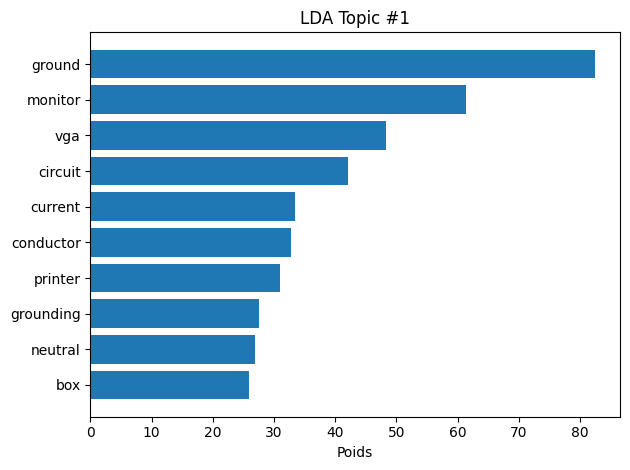

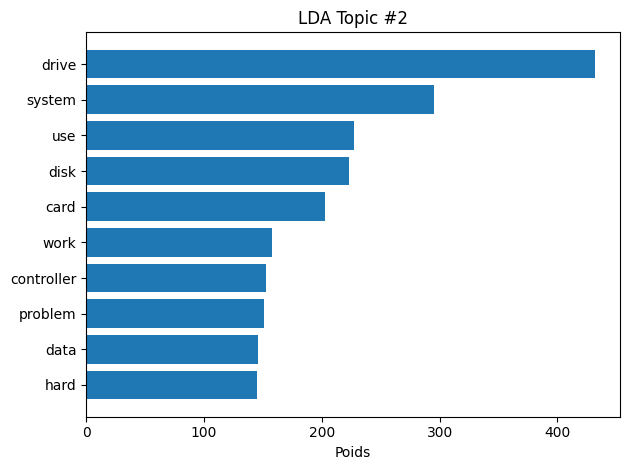

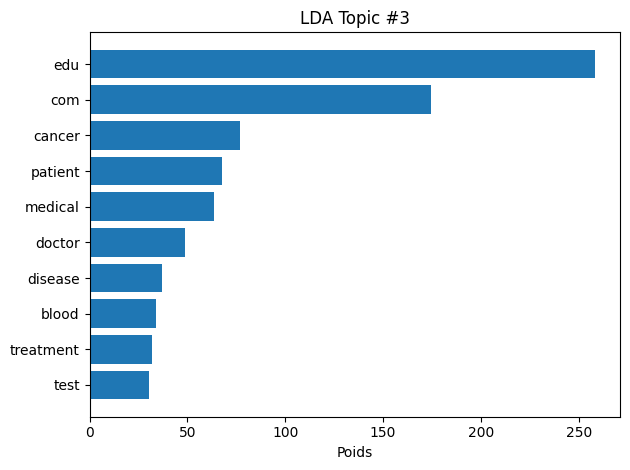

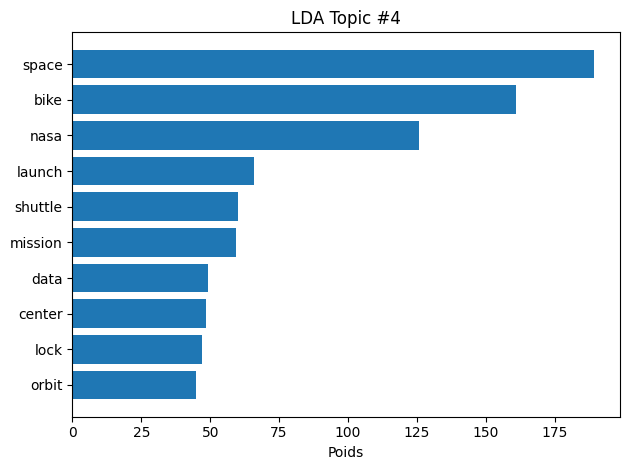

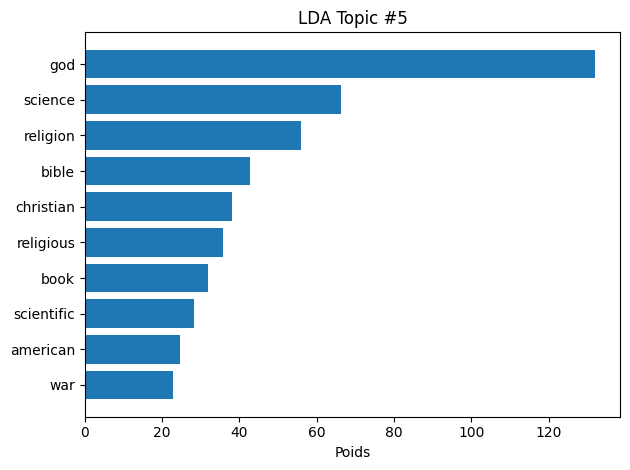

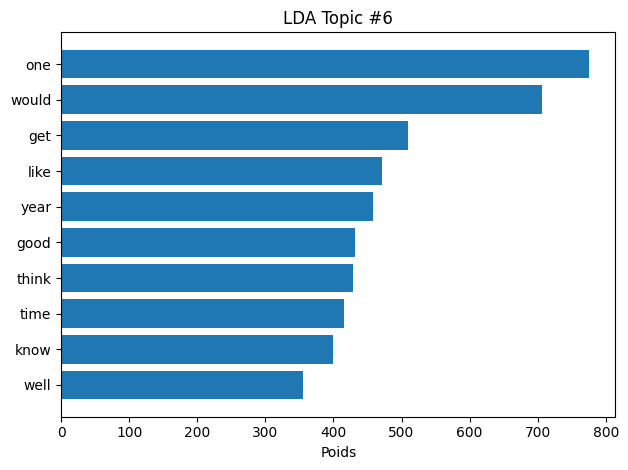

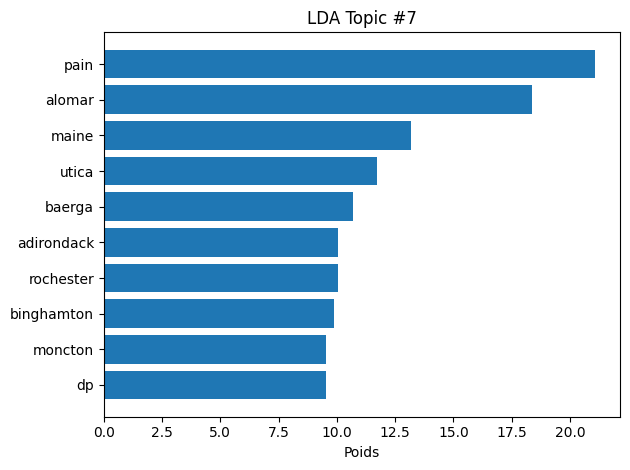

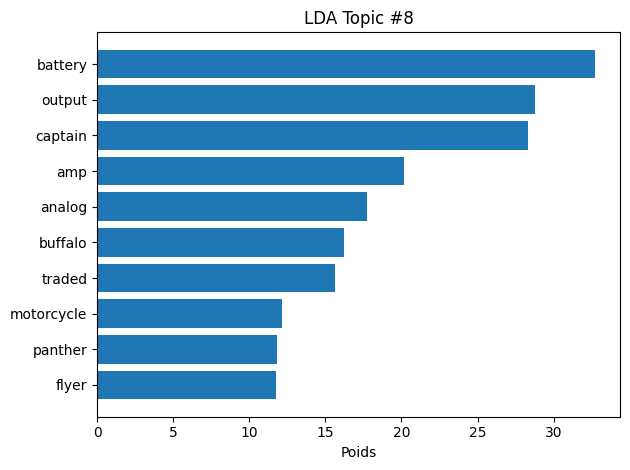

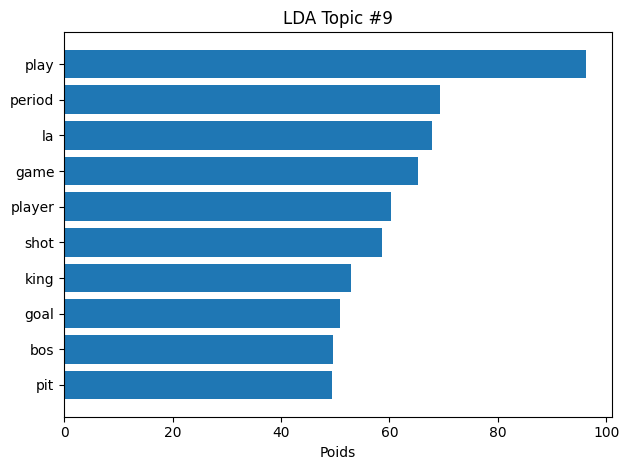

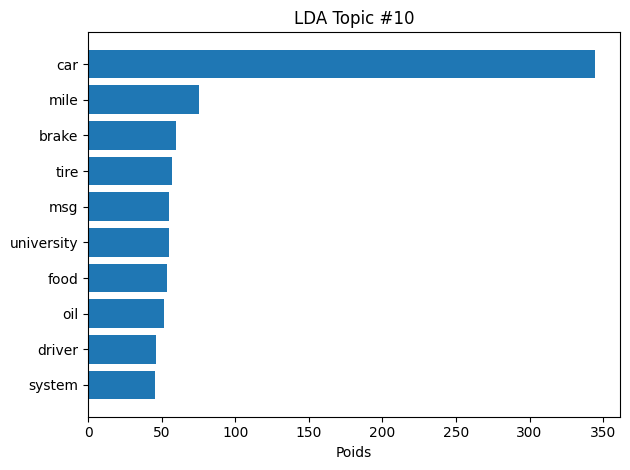

In [ ]:
import matplotlib.pyplot as plt

n_top = 10
for i, comp in enumerate(lda.components_):
    top      = comp.argsort()[:-n_top-1:-1]
    weights  = comp[top]
    words    = [terms[j] for j in top]

    plt.figure()
    plt.barh(words[::-1], weights[::-1])
    plt.title(f"LDA Topic #{i+1}")
    plt.xlabel("Poids")
    plt.tight_layout()
    plt.show()


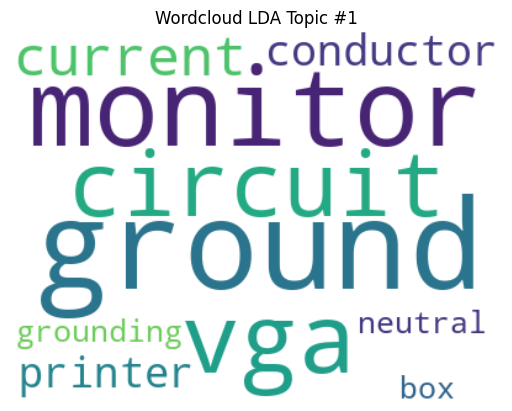

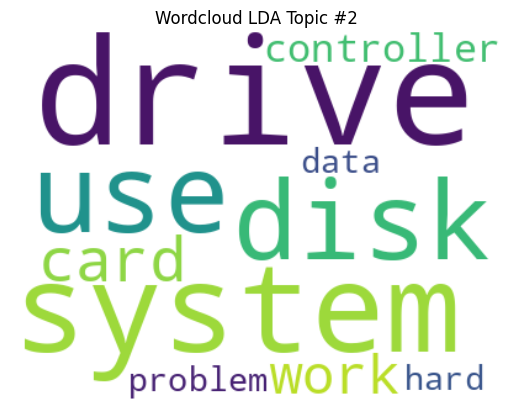

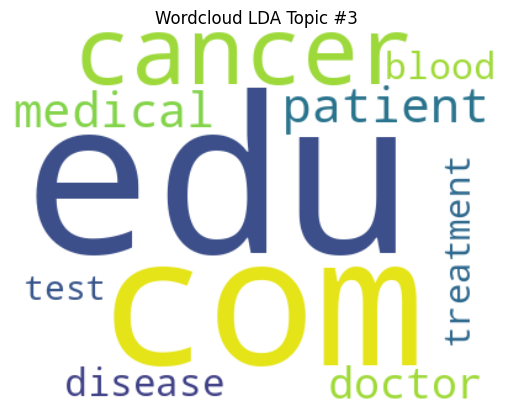

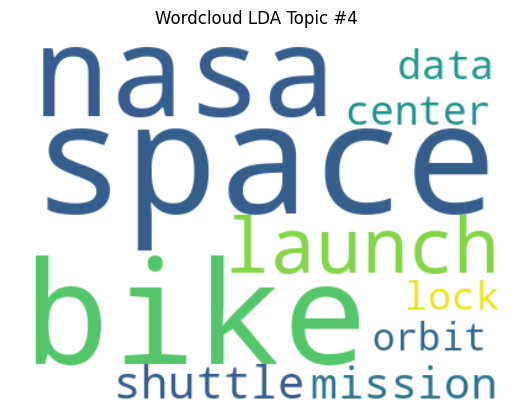

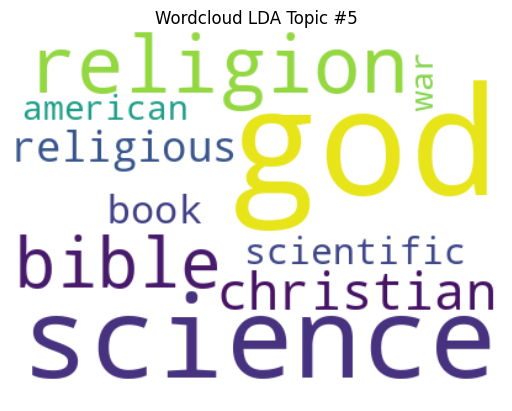

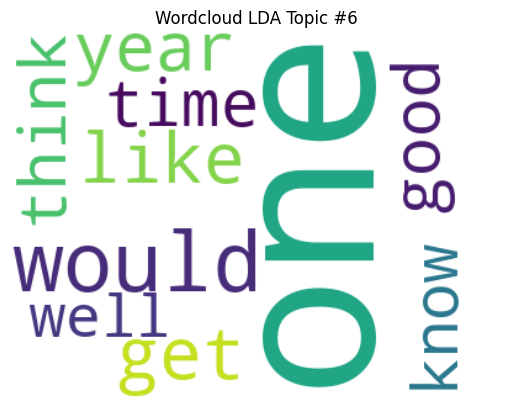

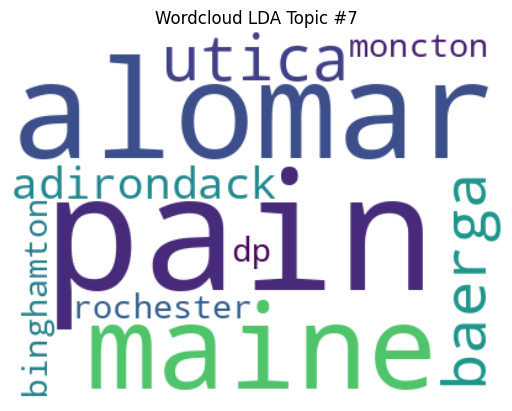

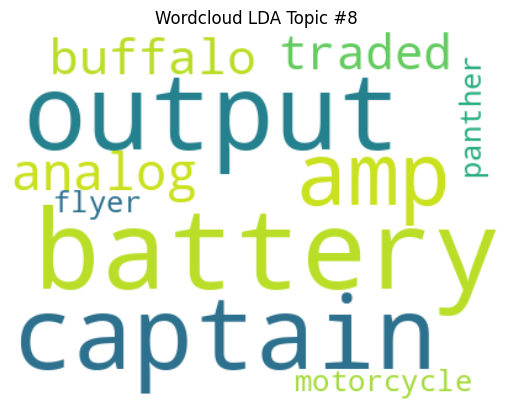

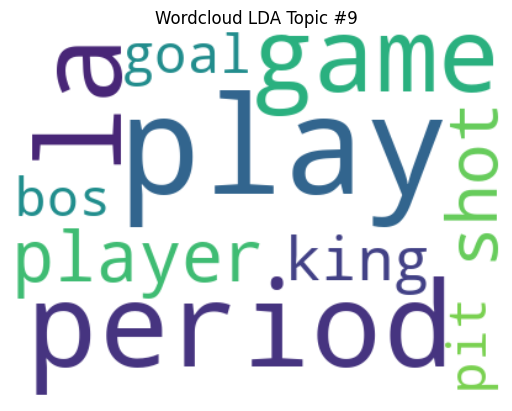

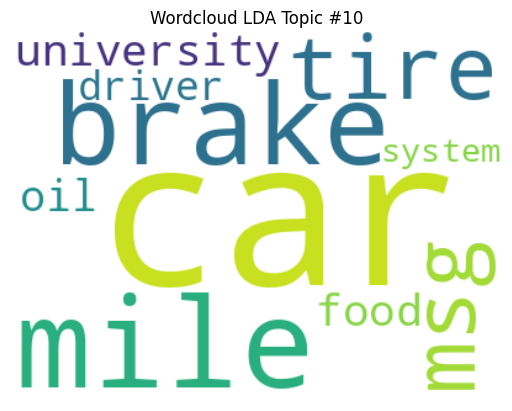

In [ ]:
from wordcloud import WordCloud

for i, comp in enumerate(lda.components_):
    freqs = {terms[j]: float(comp[j]) for j in comp.argsort()[:-n_top-1:-1]}
    wc    = WordCloud(width=400, height=300, background_color='white')
    wc.generate_from_frequencies(freqs)

    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud LDA Topic #{i+1}")
    plt.show()


Topic #1: drive, disk, controller, system, hard, bios, rom, support, feature, card
Topic #2: car, tire, brake, fluid, oil, dot, system, may, ab, braking
Topic #3: edu, com, david, uk, ac, netcom, john, ca, org, robert
Topic #4: center, cancer, research, medical, university, new, comprehensive, edu, clinical, april
Topic #5: space, nasa, data, available, ftp, information, image, archive, anonymous, system
Topic #6: god, atheist, one, posting, atheism, argument, religion, subject, response, believe
Topic #7: game, team, year, one, would, king, first, second, run, play
Topic #8: keyboard, rsi, typing, injury, one, tool, break, get, window, exercise
Topic #9: la, chi, wsh, det, tor, pit, bos, van, nyi, nyr
Topic #10: ground, conductor, grounding, neutral, current, wire, case, panel, box, service


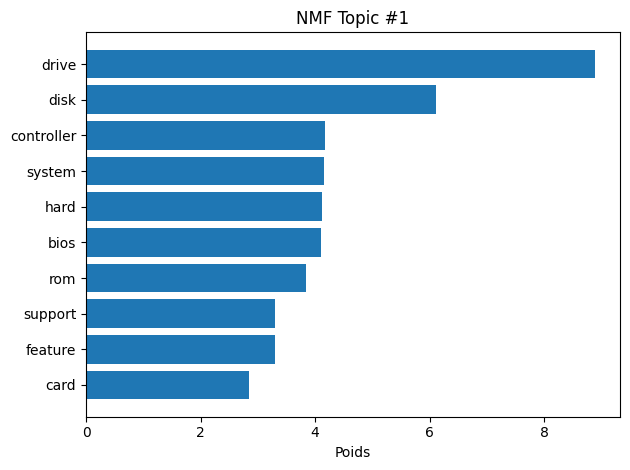

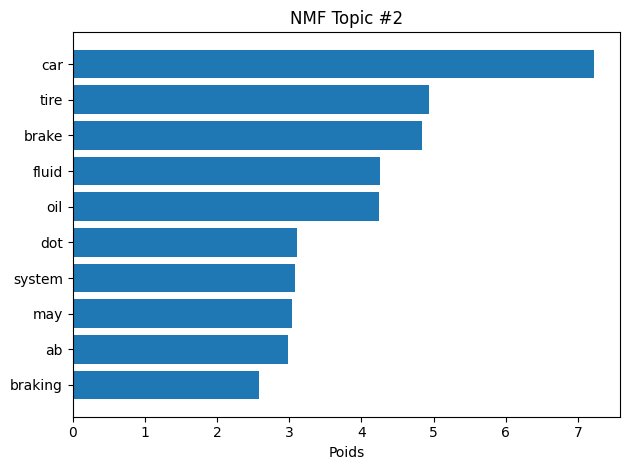

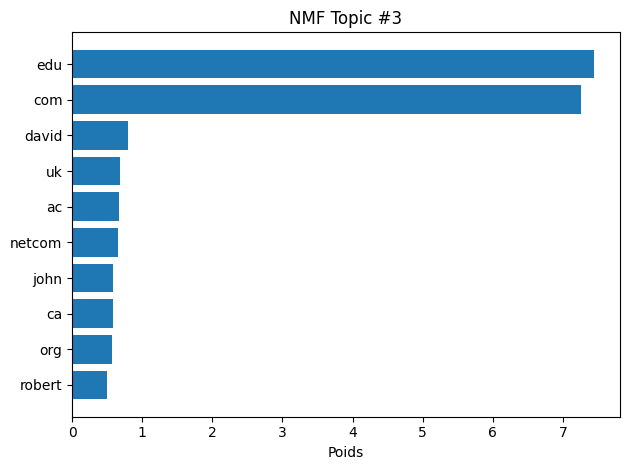

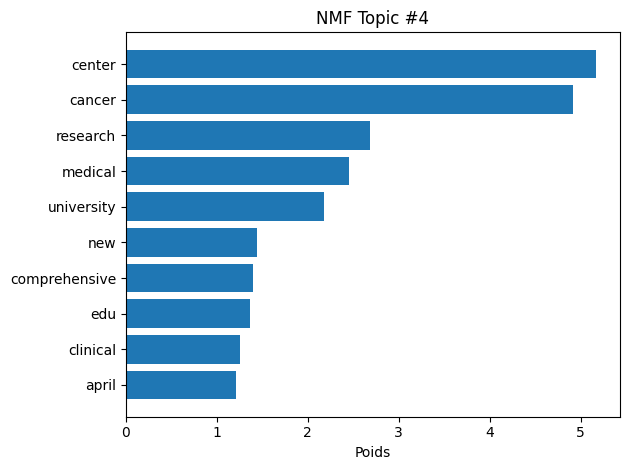

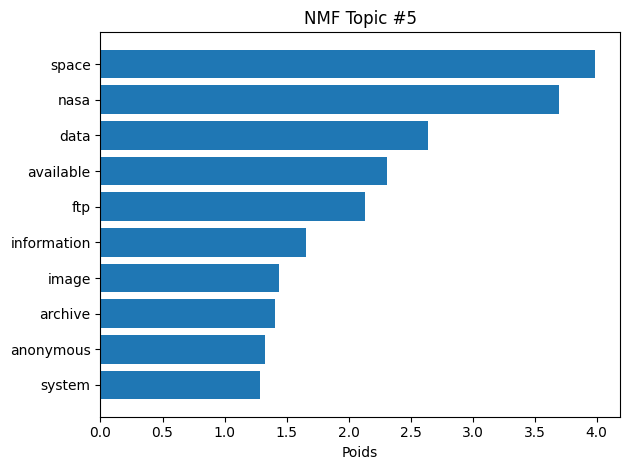

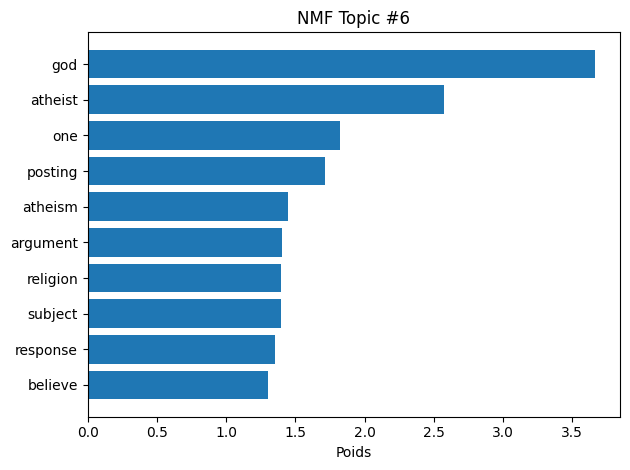

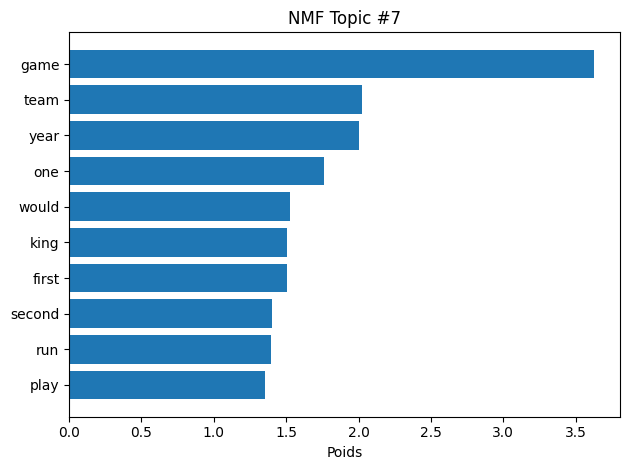

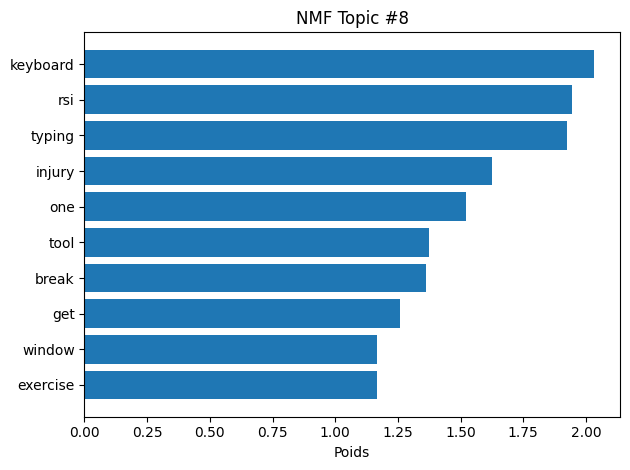

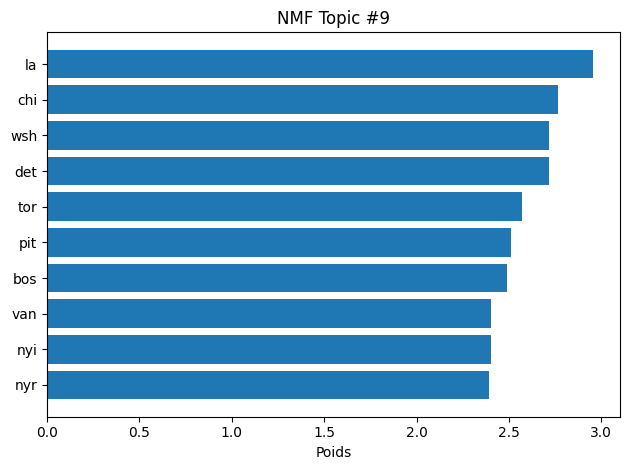

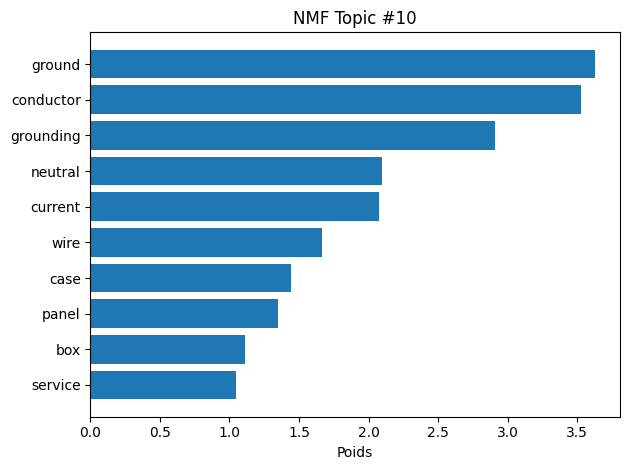

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=10, random_state=0, init='nndsvd', max_iter=200)
W   = nmf.fit_transform(tf_matrix)
H   = nmf.components_

# Top-10 mots
print_top_words(nmf, terms)

# Histogrammes
for i, comp in enumerate(H):
    top     = comp.argsort()[:-n_top-1:-1]
    weights = comp[top]
    words   = [terms[j] for j in top]

    plt.figure()
    plt.barh(words[::-1], weights[::-1])
    plt.title(f"NMF Topic #{i+1}")
    plt.xlabel("Poids")
    plt.tight_layout()
    plt.show()
